In [1]:
!pip install kaggle

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
 98% 79.0M/80.9M [00:03<00:00, 34.3MB/s]
100% 80.9M/80.9M [00:03<00:00, 22.9MB/s]


In [40]:
from zipfile import ZipFile
dataset = '/content/sentiment140.zip'
with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


#Introduction
Natural Language Processing (NLP): The discipline of computer science, artificial intelligence and linguistics that is concerned with the creation of computational models that process and understand natural language. These include: making the computer understand the semantic grouping of words (e.g. cat and dog are semantically more similar than cat and spoon), text to speech, language translation and many more

Sentiment Analysis: It is the interpretation and classification of emotions (positive, negative and neutral) within text data using text analysis techniques. Sentiment analysis allows organizations to identify public sentiment towards certain words or topics.

In this notebook, we'll develop a Sentiment Analysis model to categorize a tweet as Positive or Negative.

In [28]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

#Importing dataset

The dataset being used is the sentiment140 dataset. It contains 1,600,000 tweets extracted using the Twitter API. The tweets have been annotated (0 = Negative, 4 = Positive) and they can be used to detect sentiment.

[The training data isn't perfectly categorised as it has been created by tagging the text according to the emoji present. So, any model built using this dataset may have lower than expected accuracy, since the dataset isn't perfectly categorised.]

It contains the following 6 fields:

1. sentiment: the polarity of the tweet (0 = negative, 4 = positive)
2. ids: The id of the tweet (2087)
3. date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
4. flag: The query (lyx). If there is no query, then this value is NO_QUERY.
5. user: the user that tweeted (robotickilldozr)
6. text: the text of the tweet (Lyx is cool)
We require only the sentiment and text fields, so we discard the rest.

Furthermore, we're changing the sentiment field so that it has new values to reflect the sentiment. (0 = Negative, 1 = Positive)

In [7]:
DATASET_COLUMNS = ["sentiment","ids","date","flag","user","text"]
DATASET_ENCODING = 'ISO-8859-1'
dataset = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)


In [8]:
dataset

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [9]:
dataset = dataset[['sentiment','text']]

In [10]:
dataset

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...


In [13]:
dataset.loc[:, 'sentiment'] = dataset['sentiment'].replace(4,1)

In [14]:
dataset

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,1,Just woke up. Having no school is the best fee...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...


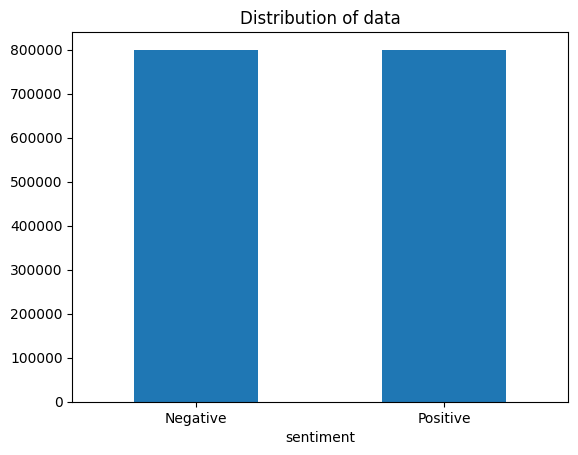

In [15]:
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data', legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

#Preprocess Text

Text Preprocessing is traditionally an important step for Natural Language Processing (NLP) tasks. It transforms text into a more digestible form so that machine learning algorithms can perform better.

The Preprocessing steps taken are:

1. Lower Casing: Each text is converted to lowercase.
2. Replacing URLs: Links starting with "http" or "https" or "www" are replaced by "URL".
3. Replacing Emojis: Replace emojis by using a pre-defined dictionary containing emojis along with their meaning. (eg: ":)" to "EMOJIsmile")
4. Replacing Usernames: Replace @Usernames with word "USER". (eg: "@Kaggle" to "USER")
5. Removing Non-Alphabets: Replacing characters except Digits and Alphabets with a space.
6. Removing Consecutive letters: 3 or more consecutive letters are replaced by 2 letters. (eg: "Heyyyy" to "Heyy")
7. Removing Stopwords: Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. (eg: "the", "he", "have")
8. Lemmatizing: Lemmatization is the process of converting a word to its base form. (e.g: “Great” to “Good”)
9. Removing Short Words: Words with length less than 2 are removed.

In [16]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [17]:
def preprocess(textdata):
  processedText = []
  wordLemm = WordNetLemmatizer()
  urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
  userPattern = '@[^\s]+'
  alphaPattern = "[^a-zA-Z0-9]"
  sequencePattern = r"(.)\1\1+"
  seqReplacePattern = r"\1\1"

  for tweet in textdata:
    tweet = tweet.lower()

    #Replace all URLs with URL
    tweet = re.sub(urlPattern, ' URL', tweet)
    #Replace all emojis
    for emoji in emojis.keys():
      tweet = tweet.replace(emoji, 'EMOJI' + emojis[emoji])
    # Replace @USERNAME to 'USER'.
    tweet = re.sub(userPattern,' USER', tweet)
        # Replace all non alphabets.
    tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    tweetwords = ''
    for word in tweet.split():
      #Checking if the word is a stopword
      #IF word not in stopwordlist:
      if len(word) > 1:
        #Lemmatizing the word
        word  = wordLemm.lemmatize(word)
        tweetwords += (word + ' ')

    processedText.append(tweetwords)

  return processedText

In [19]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [20]:
import time
t = time.time()
processedText = preprocess(text)
print(f'complete')
print(f'Time Taken: {round(time.time()-t)} seconds')

complete
Time Taken: 166 seconds


#Analysing the data

Now we're going to analyse the preprocessed data to get an understanding of it. We'll plot Word Clouds for Positive and Negative tweets from our dataset and see which words occur the most.

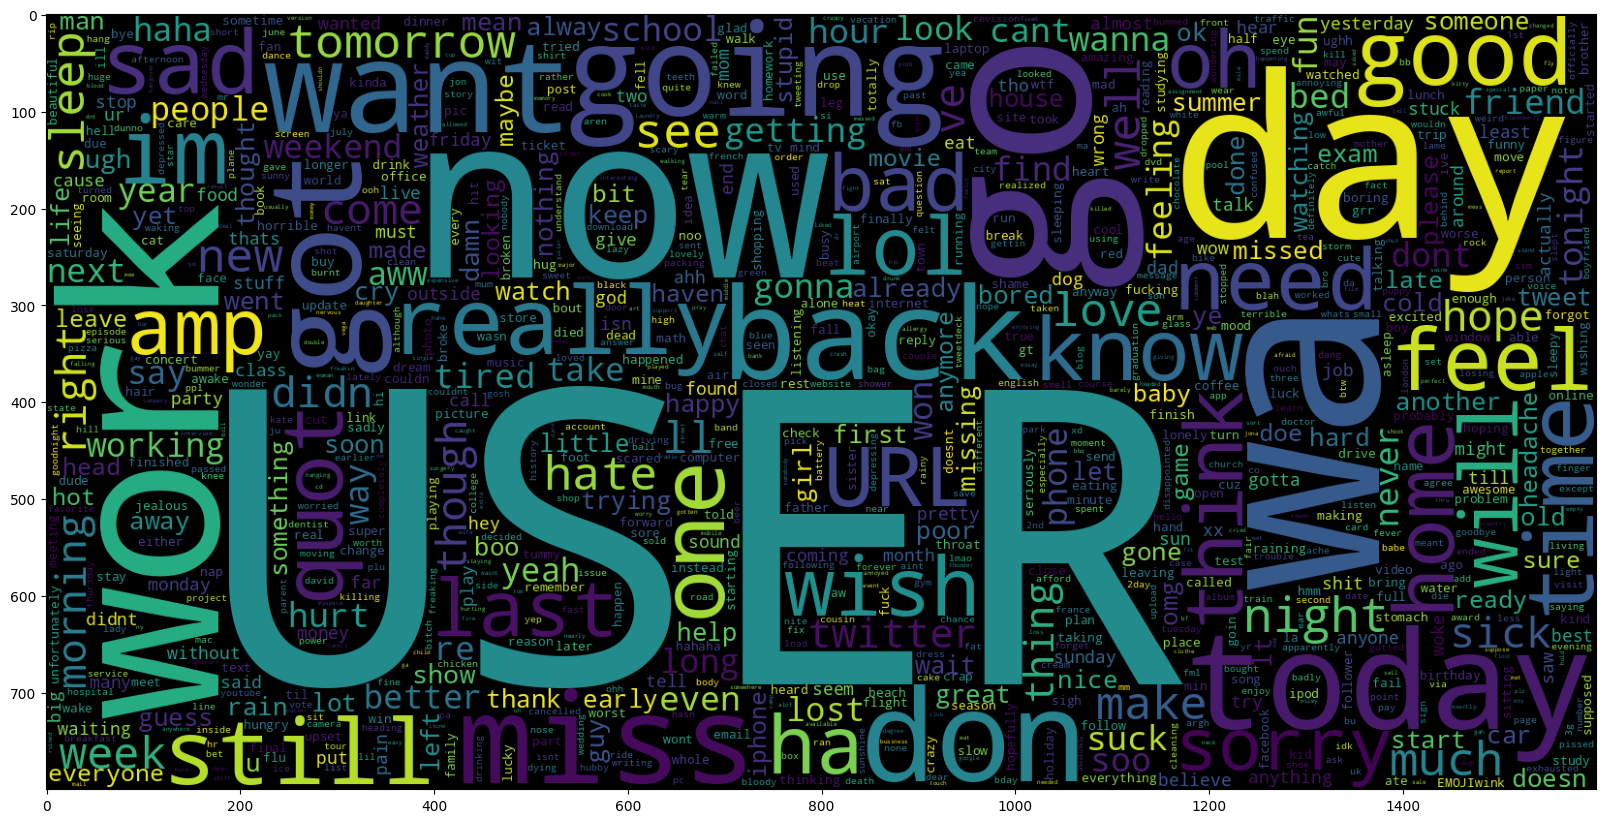

In [21]:
data_neg = processedText[:800000]
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=1000, width=1600, height=800, collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

Word Cloud for Negative Tweets

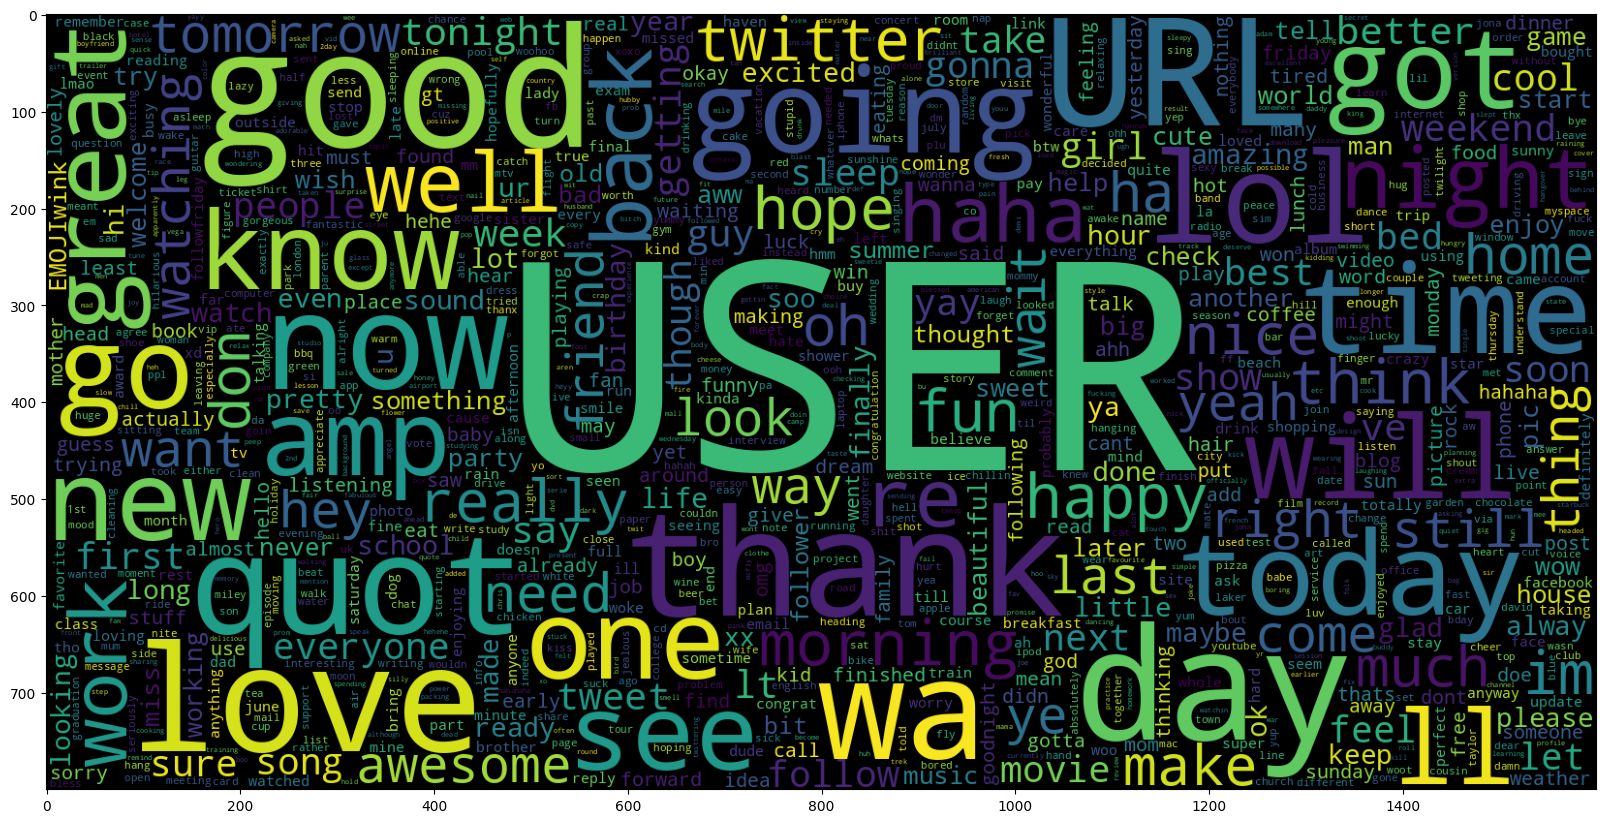

In [22]:
data_pos = processedText[800000:]
wc = WordCloud(max_words=1000, width=1600, height=800, collocations=False).generate(" ".join(data_pos))
plt.figure(figsize=(20,20))
plt.imshow(wc)

Word Cloud for Positive Tweets

#Splitting the Data
The Preprocessed Data is divided into 2 sets of data:

- Training Data: The dataset upon which the model would be trained on. Contains 95% data.
- Test Data: The dataset upon which the model would be tested against. Contains 5% data.

In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(processedText, sentiment, test_size=0.05, random_state=0)
print(f'Data split done')

Data split done


#TF-IDF Vectoriser

TF-IDF indicates what the importance of the word is in order to understand the document or dataset. Let us understand with an example. Suppose you have a dataset where students write an essay on the topic, My House. In this dataset, the word a appears many times; it’s a high frequency word compared to other words in the dataset. The dataset contains other words like home, house, rooms and so on that appear less often, so their frequency are lower and they carry more information compared to the word. This is the intuition behind TF-IDF.

TF-IDF Vectoriser converts a collection of raw documents to a matrix of TF-IDF features. The Vectoriser is usually trained on only the X_train dataset.

ngram_range is the range of number of words in a sequence. [e.g "very expensive" is a 2-gram that is considered as an extra feature separately from "very" and "expensive" when you have a n-gram range of (1,2)]

max_features specifies the number of features to consider. [Ordered by feature frequency across the corpus].

In [26]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectorizer Fitted Successfully')
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

Vectorizer Fitted Successfully
No. of feature_words:  500000


#Tranforming the dataset

Transforming the X_train and X_test dataset into matrix of TF-IDF Features by using the TF-IDF Vectoriser. This datasets will be used to train the model and test against it.


In [27]:
X_train = vectoriser.transform(X_train)
X_test = vectoriser.transform(X_test)
print(f'Data Transformed')

Data Transformed


#Creating and Evaluating Models

We're creating 3 different types of model for our sentiment analysis problem:

- Bernoulli Naive Bayes (BernoulliNB)
- Linear Support Vector Classification (LinearSVC)
- Logistic Regression (LR)

Since our dataset is not skewed, i.e. it has equal number of Positive and Negative Predictions. We're choosing Accuracy as our evaluation metric. Furthermore, we're plotting the Confusion Matrix to get an understanding of how our model is performing on both classification types.

Evaluate Model Function

In [46]:
def model_Evaluate(model, X_test, Y_test):
    """
    Evaluate a classification model and display results.

    Args:
        model: Trained model to evaluate.
        X_test: Test feature data.
        Y_test: Test target data.
    """
    # Predict values for the Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset
    print("Classification Report:")
    print(classification_report(Y_test, y_pred))

    # Compute the Confusion Matrix
    cf_matrix = confusion_matrix(Y_test, y_pred)

    # Define categories
    categories = ['Negative', 'Positive']

    # Plot the Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d',
                xticklabels=categories, yticklabels=categories)
    plt.xlabel("Predicted Values", fontsize=14)
    plt.ylabel("Actual Values", fontsize=14)
    plt.title("Confusion Matrix", fontsize=18)
    plt.show()

In [47]:
BNBmodel = BernoulliNB(alpha=2)
BNBmodel.fit(X_train, Y_train)

BernoulliNB(alpha=2)

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.79      0.80     39989
           1       0.80      0.81      0.80     40011

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



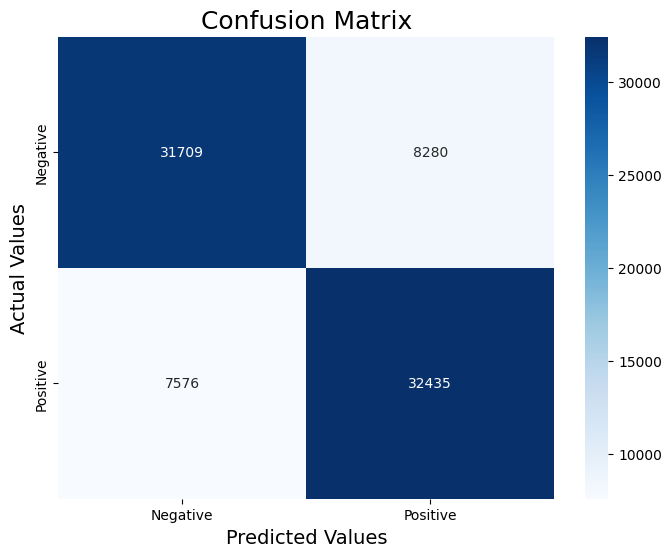

In [48]:
model_Evaluate(BNBmodel, X_test, Y_test)

In [49]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, Y_train)

LinearSVC()

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.81      0.82     39989
           1       0.81      0.83      0.82     40011

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000



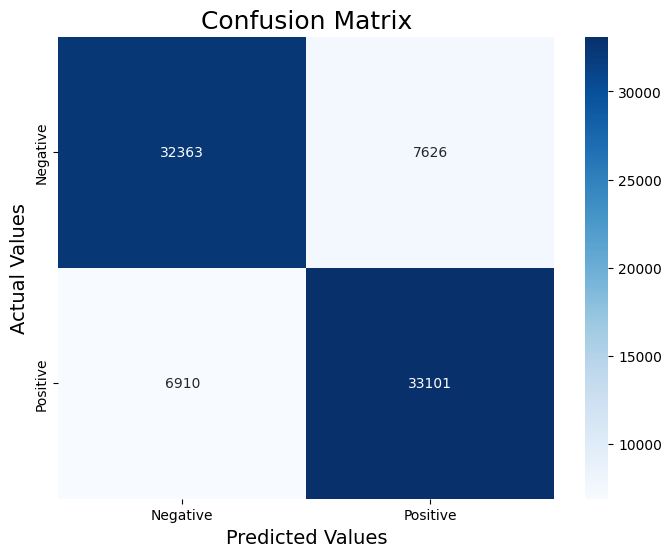

In [50]:
model_Evaluate(SVCmodel, X_test, Y_test)

In [51]:
LRmodel = LogisticRegression(C=2, max_iter=1000, n_jobs=-1)
LRmodel.fit(X_train, Y_train)

LogisticRegression(C=2, max_iter=1000, n_jobs=-1)

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.82      0.83     39989
           1       0.82      0.84      0.83     40011

    accuracy                           0.83     80000
   macro avg       0.83      0.83      0.83     80000
weighted avg       0.83      0.83      0.83     80000



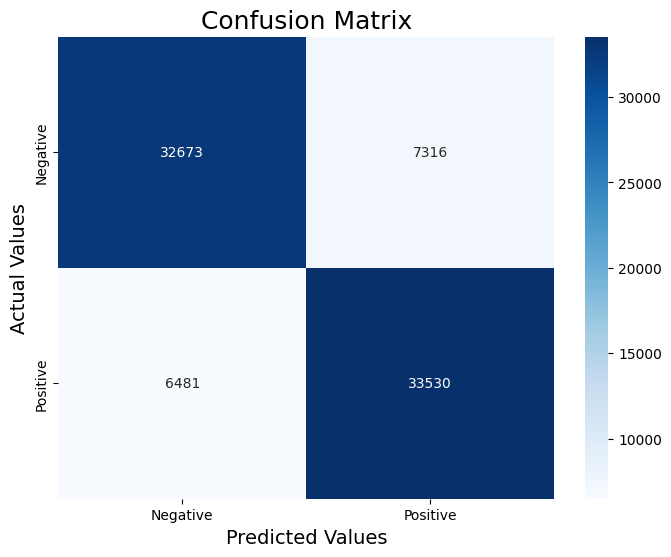

In [52]:
model_Evaluate(LRmodel, X_test, Y_test)

As after conversion of this value in percentage We can clearly see that the Logistic Regression Model performs the best out of all the different models that we tried. It achieves nearly 82% accuracy while classifying the sentiment of a tweet.

Although it should also be noted that the BernoulliNB Model is the fastest to train and predict on. It also achieves 80% accuracy while calssifying.

In [56]:
def predict(vectoriser, model, text):
    # Predict the sentiment
    textdata = vectoriser.transform(preprocess(text))
    sentiment = model.predict(textdata)

    # Make a list of text with sentiment manually
    data = []
    for i in range(len(text)):
        data.append((text[i], sentiment[i]))

    # Convert the list into a pandas DataFrame
    df = pd.DataFrame(data, columns=['text', 'sentiment'])
    df = df.replace([0, 1], ['Negative', 'Positive'])
    return df

# Sample input text
text = ["I hate twitter",
        "May the Force be with you.",
        "Mr. Stark, I don't feel so good"]

# Assuming `vectoriser` and `LRmodel` are already defined and trained
df = predict(vectoriser, LRmodel, text)
print(df.head())

                              text sentiment
0                   I hate twitter  Negative
1       May the Force be with you.  Positive
2  Mr. Stark, I don't feel so good  Negative
